#### Importações e Funções de Pré-processamento

In [1]:
import pandas as pd
import re
import numpy as np
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
import spacy
import tomotopy as tp
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pyLDAvis
from gensim import corpora
from gensim.models import CoherenceModel
import scipy.stats as stats
from tqdm import tqdm

import string
import emoji

# emojis and punctuation
punct = list(string.punctuation) + ["\n"]
keep_punct = ["-"]
[punct.remove(item) for item in keep_punct if item in punct]

emojis_list = list(emoji.EMOJI_DATA.keys())
emojis_list += ["\n"]
emojis_punct = emojis_list + punct

def processEmojisPunctuation(text, remove_punct=False, remove_emoji=False):
    """
    Put spaces between emojis. Removes punctuation.
    """
    # get all unique chars
    chars = set(text)
    # for each unique char in text, do:
    for c in chars:
        if remove_punct:  # remove punctuation
            if c in punct:
                text = text.replace(c, " ")

        if remove_emoji:  # remove emojis
            if c in emojis_list:
                text = text.replace(c, " ")
        else:  # put spaces between emojis
            if c in emojis_list:
                text = text.replace(c, " " + c + " ")

    text = re.sub(" +", " ", text)
    return text

# stop words removal
stop_words = list(stopwords.words("portuguese"))
new_stopwords = [
    "aí", "pra", "vão", "vou", "onde", "tá", "pois", "so", "deu",
    "ai", "ta", "alguem", "ne", "cara", "to", "mim", "la", "vcs",
    "tbm", "tudo", "a", "O", "uma", "de", "que"
]
stop_words = stop_words + new_stopwords
final_stop_words = []
for sw in stop_words:
    sw = " " + sw + " "
    final_stop_words.append(sw)

def removeStopwords(text):
    for sw in final_stop_words:
        text = text.replace(sw, " ")
    return text

# lemmatization
nlp = spacy.load("pt_core_news_sm")

def lemmatization(text):
    doc = nlp(text)
    for token in doc:
        if token.text != token.lemma_:
            text = text.replace(token.text, token.lemma_)
    return text

def domainUrl(text):
    """
    Substitutes an URL in a text for the domain of this URL
    Input: an string
    Output: the string with the modified URL
    """
    if "http" in text:
        re_url = r"[^\s]*https*://[^\s]*"
        matches = re.findall(re_url, text, flags=re.IGNORECASE)
        for m in matches:
            domain = m.split("//")[1].split("/")[0]
            text = re.sub(re_url, domain, text, 1)
        return text
    else:
        return text

def processLoL(text):
    re_kkk = r"kkk*"
    t = re.sub(re_kkk, "kkk", text, flags=re.IGNORECASE)
    return t

def preprocess(text, semi=False, rpunct=False, remoji=False):
    text = text.lower().strip()
    text = domainUrl(text)
    text = processLoL(text)
    text = processEmojisPunctuation(text, remove_punct=rpunct, remove_emoji=remoji)
    if semi:
        return text
    text = removeStopwords(text)
    #text = lemmatization(text)
    return text

#### Carregar e Pré-processar o Dataset

In [2]:
# Carregar o dataset
dataset = pd.read_csv('../transcricoes_medium/m_transc_pe.paulo.csv')

# Limpeza e preprocessamento
dataset = dataset[:3000]
dataset['Transcription'] = dataset['Transcription'].apply(lambda x: preprocess(x, semi=True, rpunct=True, remoji=True))
dataset.dropna(subset=['Transcription'], inplace=True)
clean_messages = dataset['Transcription'].apply(lambda x: preprocess(x, semi=True, rpunct=True, remoji=True))

# Tokenização e preparação dos textos
texts = [doc.split() for doc in clean_messages]

#### Definir Funções para Diversidade de Tópicos, iRBO e Jaccard

In [3]:
def proportion_unique_words(topics, topk=10):
    """
    Calcular a proporção de palavras únicas nos tópicos

    Parameters
    ----------
    topics: lista de listas de palavras
    topk: top k palavras nas quais a diversidade do tópico será calculada
    """
    if topk > len(topics[0]):
        raise Exception('Words in topics are less than '+str(topk))
    else:
        unique_words = set()
        for topic in topics:
            unique_words = unique_words.union(set(topic[:topk]))
        puw = len(unique_words) / (topk * len(topics))
        return puw

def rank_biased_overlap(list1, list2, p=0.9):
    def average_overlap(list1, list2, depth):
        set1 = set(list1[:depth])
        set2 = set(list2[:depth])
        return len(set1 & set2) / depth

    if len(list1) > len(list2):
        list1, list2 = list2, list1

    S, rbo_ext = 0.0, 0.0
    for depth in range(1, len(list1) + 1):
        avg_overlap = average_overlap(list1, list2, depth)
        rbo_ext += avg_overlap * p ** depth
        S += avg_overlap * p ** depth / depth

    S *= (1 - p) / p
    rbo_ext *= (1 - p)
    rbo_res = S + rbo_ext
    return rbo_res

def calculate_irbo(pt_model, topk=10):
    """
    Calcular o iRBO entre tópicos
    """
    topics = [pt_model.get_topic_words(k, top_n=topk) for k in range(pt_model.k)]
    topics = [[word for word, _ in topic] for topic in topics]
    irbo_values = []
    for i in range(len(topics)):
        for j in range(i + 1, len(topics)):
            irbo_value = rank_biased_overlap(topics[i], topics[j], p=0.9)
            irbo_values.append(irbo_value)
    return np.mean(irbo_values)

def calculate_jaccard_distance(pt_model, topk=10):
    """
    Calcular a distância de Jaccard entre tópicos
    """
    def jaccard_distance(set1, set2):
        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))
        return 1 - intersection / union

    topics = [pt_model.get_topic_words(k, top_n=topk) for k in range(pt_model.k)]
    topics = [set([word for word, _ in topic]) for topic in topics]
    jaccard_values = []
    for i in range(len(topics)):
        for j in range(i + 1, len(topics)):
            jaccard_value = jaccard_distance(topics[i], topics[j])
            jaccard_values.append(jaccard_value)
    return np.mean(jaccard_values)


#### Treinar Modelos e Calcular Métricas

In [4]:
# Definir a faixa de tópicos
start = 2
limit = 30
step = 2

metric_values = []

# Treinamento dos modelos de tópicos e cálculo das métricas
for num_topics in tqdm(range(start, limit, step)):
    pt_model = tp.LDAModel(k=num_topics, seed=42)
    for text in texts:
        pt_model.add_doc(text)
    pt_model.train(100)  # Esse 100 vem de um hiperparametro, pode mudar depois

    metric_value_row = {'num_topics': num_topics}  # Armazena o número de tópicos

    # Calcular as métricas de coerência
    for preset in ('u_mass', 'c_uci', 'c_npmi', 'c_v'):
        coh = tp.coherence.Coherence(pt_model, coherence=preset)
        average_coherence = coh.get_score()
        metric_value_row[preset] = average_coherence

    # Calcular a perplexidade
    metric_value_row['perplexity'] = pt_model.perplexity

    # Calcular a diversidade dos tópicos
    topics = [pt_model.get_topic_words(k, top_n=10) for k in range(num_topics)]
    topics = [[word for word, _ in topic] for topic in topics]
    metric_value_row['diversity'] = proportion_unique_words(topics, topk=10)

    # Calcular o iRBO entre os tópicos
    metric_value_row['irbo'] = calculate_irbo(pt_model, topk=10)

    # Calcular a distância de Jaccard entre os tópicos
    metric_value_row['jaccard'] = calculate_jaccard_distance(pt_model, topk=10)

    metric_values.append(metric_value_row)

# Verificar o conteúdo de metric_values
print(metric_values)

# Salvar as métricas em um CSV
metrics_df = pd.DataFrame(metric_values)
metrics_df.to_csv('_pe_paulo_topic_model_metrics.csv', index=False)


  0%|                                                                      | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_27538/2155094522.py:13: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  pt_model.train(100)  # Esse 100 vem de um hiperparametro, pode mudar depois
100%|█████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  7.71it/s]

[{'num_topics': 2, 'u_mass': -1.333540366327991, 'c_uci': -1.6762801304432684, 'c_npmi': -0.07713045629577814, 'c_v': 0.5895046677440405, 'perplexity': 479.6726604219855, 'diversity': 0.8, 'irbo': 0.43179278339112237, 'jaccard': 0.75}, {'num_topics': 4, 'u_mass': -1.3141124358822616, 'c_uci': -1.456487114362782, 'c_npmi': -0.047837876402673105, 'c_v': 0.6788108897395432, 'perplexity': 433.98323591342506, 'diversity': 0.7, 'irbo': 0.3179277570635246, 'jaccard': 0.830065359477124}, {'num_topics': 6, 'u_mass': -2.2439332255717592, 'c_uci': -2.730745020050673, 'c_npmi': -0.07491536139812627, 'c_v': 0.6938279919947187, 'perplexity': 447.2331655168995, 'diversity': 0.7333333333333333, 'irbo': 0.11804034906245749, 'jaccard': 0.9052230248824678}, {'num_topics': 8, 'u_mass': -4.047713663405127, 'c_uci': -2.8109197067033977, 'c_npmi': -0.044937261505529985, 'c_v': 0.7255876123905183, 'perplexity': 436.2428648658013, 'diversity': 0.7125, 'irbo': 0.1360031428250428, 'jaccard': 0.9204199223549068},

#### Visualizar as Métricas

Comprimento de metric_values: 14
x: 14, coherence_values: 14


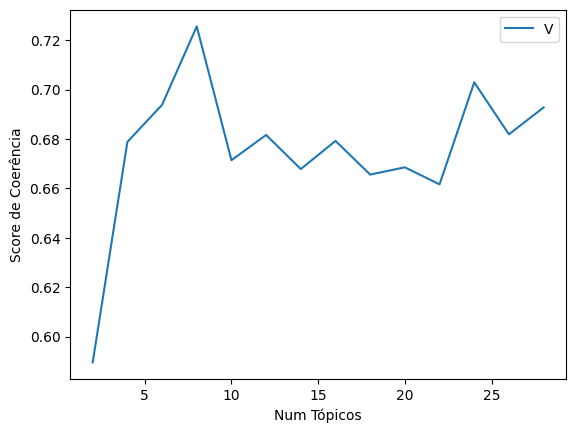

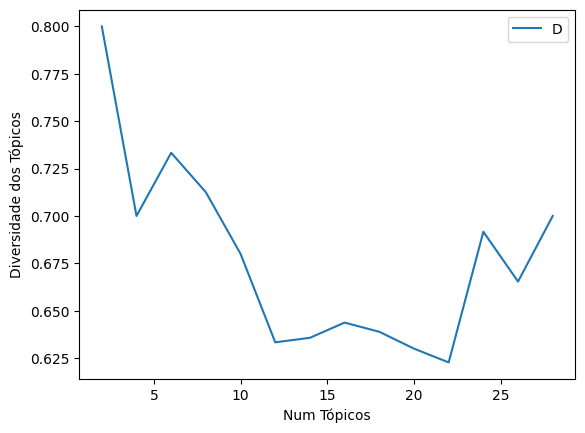

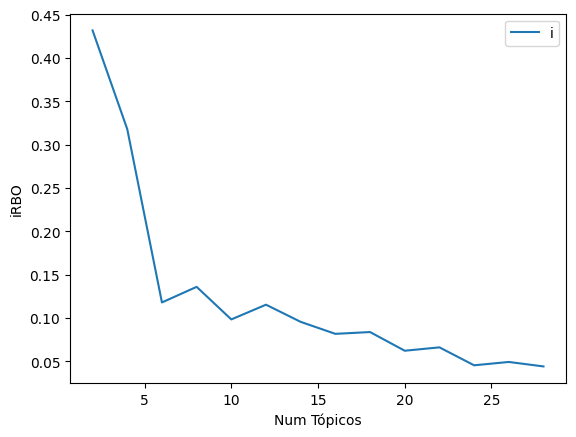

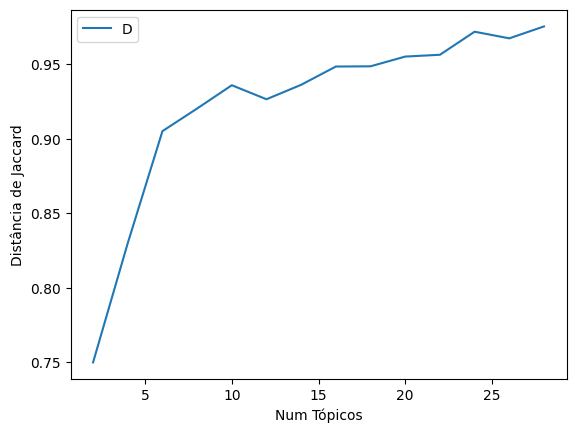

In [5]:
# Verifique o comprimento das listas
print("Comprimento de metric_values:", len(metric_values))

# Extrair valores de coerência
coherence_values = [x['c_v'] for x in metric_values]
x = range(start, start + len(coherence_values) * step, step)

# Verificar as dimensões das listas
print(f"x: {len(x)}, coherence_values: {len(coherence_values)}")

# Plotar a coerência dos tópicos
if len(x) == len(coherence_values):
    plt.plot(x, coherence_values)
    plt.xlabel("Num Tópicos")
    plt.ylabel("Score de Coerência")
    plt.legend(("Valores de Coerência"), loc='best')
    plt.savefig("coherence_score.png")
    plt.show()
else:
    print("As listas x e coherence_values têm dimensões diferentes. Verifique os cálculos das métricas.")

# Plotar a diversidade dos tópicos
diversity_values = [x['diversity'] for x in metric_values]
x = range(start, start + len(diversity_values) * step, step)

if len(x) == len(diversity_values):
    plt.plot(x, diversity_values)
    plt.xlabel("Num Tópicos")
    plt.ylabel("Diversidade dos Tópicos")
    plt.legend(("Diversidade dos Tópicos"), loc='best')
    plt.savefig("diversity_score.png")
    plt.show()
else:
    print("As listas x e diversity_values têm dimensões diferentes. Verifique os cálculos das métricas.")

# Plotar o iRBO entre os tópicos
irbo_values = [x['irbo'] for x in metric_values]
x = range(start, start + len(irbo_values) * step, step)

if len(x) == len(irbo_values):
    plt.plot(x, irbo_values)
    plt.xlabel("Num Tópicos")
    plt.ylabel("iRBO")
    plt.legend(("iRBO"), loc='best')
    plt.savefig("irbo_score.png")
    plt.show()
else:
    print("As listas x e irbo_values têm dimensões diferentes. Verifique os cálculos das métricas.")

# Plotar a distância de Jaccard entre os tópicos
jaccard_values = [x['jaccard'] for x in metric_values]
x = range(start, start + len(jaccard_values) * step, step)

if len(x) == len(jaccard_values):
    plt.plot(x, jaccard_values)
    plt.xlabel("Num Tópicos")
    plt.ylabel("Distância de Jaccard")
    plt.legend(("Distância de Jaccard"), loc='best')
    plt.savefig("jaccard_score.png")
    plt.show()
else:
    print("As listas x e jaccard_values têm dimensões diferentes. Verifique os cálculos das métricas.")


#### Salvar e Visualizar Tópicos

In [6]:
# Salvar os tópicos em um CSV e imprimir os tópicos
def save_and_print_topics(pt_model, num_topics, num_words, filename):
    topics = []
    for k in range(num_topics):
        topic_words = pt_model.get_topic_words(k, top_n=num_words)
        topics.append([word for word, prob in topic_words])
        print(f'Tópico {k}: {[word for word, prob in topic_words]}')

    topics_df = pd.DataFrame(topics)
    topics_df.insert(0, 'Tópico', range(num_topics))
    topics_df.to_csv(filename, index=False)

save_and_print_topics(pt_model, num_topics=10, num_words=30, filename='_pe_paulo_tomotopy.csv')


Tópico 0: ['em', 'do', 'por', 'nome', 'cristo', 'para', 'paixão', 'vós', 'mãe', 'muito', 'tudo', 'nossas', 'as', 'pecados', 'nós', 'bem', 'a', 'meditamos', 'realizá-las', 'comece', 'termine', 'fizermos', 'volta', 'rogai', 'bonito', 'aquilo', 'ajudai-nos', 'ações', 'diálogo', 'inspirai']
Tópico 1: ['bom', 'céu', 'né', 'pastor', 'falar', 'então', 'depois', 'meio', 'essa', 'querem', 'grave', 'contexto', 'missa', 'templo', '10', 'ontem', 'tá', 'estão', 'pergunta', 'famílias', 'daqueles', 'igreja', 'tremendo', 'apedrejar', 'devido', 'chegou', 'acabou', 'fatalidade', 'amenizar', 'meditávamos']
Tópico 2: ['o', 'do', 'em', 'com', 'aqui', 'estamos', 'pão', 'já', 'mais', 'lendo', 'sexta-feira', '6', 'vai', 'cura', 'eu', 'desde', 'falar', 'nesse', 'também', 'mesmo', '14', 'leitura', 'onde', 'epifania', 'lucas', 'paschal', 'à', 'sou', 'seia', 'meu']
Tópico 3: ['a', 'e', 'grande', 'alegria', 'com', 'irmãos', 'meus', 'dia', 'irmãs', 'da', 'um', 'quaresma', 'celebramos', 'sábado', 'então', 'verdadeir

#### Nuvem de Palavras e Visualização Interativa

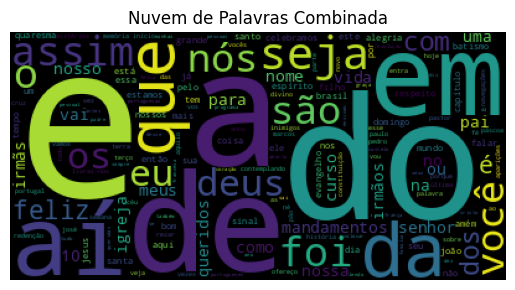

/home/nanda/.pyenv/versions/3.10.2/lib/python3.10/site-packages/pyLDAvis/_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


FileNotFoundError: [Errno 2] No such file or directory: 'https://cdn.jsdelivr.net/gh/bmabey/pyLDAvis@3.4.0/pyLDAvis/js/ldavis.v1.0.0.css'

In [7]:
# Nuvem de Palavras Única
def plot_combined_word_cloud(model, num_topics, filename):
    combined_dict = {}
    for t in range(num_topics):
        topic_words = model.get_topic_words(t, top_n=30)
        for word, weight in topic_words:
            if word in combined_dict:
                combined_dict[word] += weight
            else:
                combined_dict[word] = weight

    plt.figure()
    plt.imshow(WordCloud().fit_words(combined_dict))
    plt.axis("off")
    plt.title("Nuvem de Palavras Combinada")
    plt.savefig(filename)  # Salvar a nuvem de palavras
    plt.show()

plot_combined_word_cloud(pt_model, num_topics=pt_model.k, filename='word_cloud.png')

# Preparar os dados para visualização com pyLDAvis
topic_term_dists = np.stack([pt_model.get_topic_word_dist(k) for k in range(pt_model.k)])
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in pt_model.docs])
doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)
doc_lengths = np.array([len(doc.words) for doc in pt_model.docs])
vocab = list(pt_model.used_vocabs)
term_frequency = pt_model.used_vocab_freq

prepared_data = pyLDAvis.prepare(
    topic_term_dists=topic_term_dists,
    doc_topic_dists=doc_topic_dists,
    doc_lengths=doc_lengths,
    vocab=vocab,
    term_frequency=term_frequency
)

# Salvar a visualização em um arquivo HTML
pyLDAvis.save_html(prepared_data, '_pe_paulo_lda_vis.html')
pyLDAvis.show(prepared_data)
